<a href="https://colab.research.google.com/github/MohammadFebriyanto/TrashDetection/blob/master/tree/master/ML/transfer_learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import zipfile

In [ ]:
# Download file zip berisikan gambar
!wget --no-check-certificate \
  https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip?raw=true \
  -O /tmp/trashnet.zip

--2020-06-17 05:18:31--  https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip [following]
--2020-06-17 05:18:32--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2020-06-17 05:18:32--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... con

In [ ]:
# Ekstrak file Zip
local_zip = '/tmp/trashnet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
def image_plot(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs[:5]]
    
    plt.figure(figsize=(12,14))
    
    for idx, img_path in enumerate(item_files):
        plt.subplot(5,5,idx+1)
        
        img=plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

In [ ]:
print(os.listdir('/tmp/dataset-resized'))

['plastic', '.DS_Store', 'trash', 'metal', 'cardboard', 'glass', 'paper']


In [ ]:
data_path = '/tmp/dataset-resized'

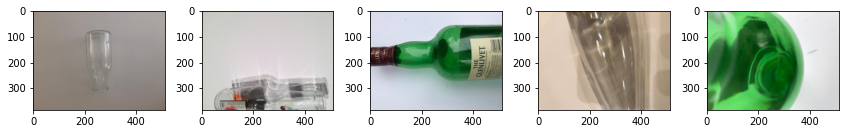

In [ ]:
image_plot(data_path+'/glass')

In [ ]:
train = ImageDataGenerator(rotation_range = 90,horizontal_flip=True, vertical_flip=True, validation_split=0.2, rescale=1./255,
                           shear_range=0.1,zoom_range=0.1, width_shift_range=0.1,height_shift_range=0.1,fill_mode='nearest')

test = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train.flow_from_directory(data_path,target_size=(224,224),batch_size=11, class_mode='categorical',
                                            subset='training')

test_generator = test.flow_from_directory(data_path,target_size=(224,224),batch_size=11, class_mode='categorical',
                                            subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
# !wget --no-check-certificate \
#     https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5 \
#     -O /tmp/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
  
import tensorflow.keras.applications.vgg16

# local_weights_file = '/tmp/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

pre_trained_model = tensorflow.keras.applications.VGG16(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = "imagenet")

# pre_trained_model.load_weights(local_weights_file)
# pre_trained_model.trainable = True
# fine_tune_at = 153
for layer in pre_trained_model.layers:
  layer.trainable = False
  
#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [ ]:
len(pre_trained_model.layers)

19

In [ ]:
from tensorflow.keras.optimizers import SGD

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x) 
x = layers.Dense(64, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation='relu')(x)                 
# Add a final softmax layer for classification
x = layers.Dense  (6, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_path='new_transfer_learning.h5'
checkpoint1 = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model.output_shape

(None, 6)

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_path='new_transfer_learning.h5'
checkpoint1 = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            steps_per_epoch = step_size_train,
            epochs = 80,
            validation_steps = step_size_test,
            verbose = 1,
            callbacks=callbacks_list)

Epoch 1/80
184/184 [==============================] - ETA: 0s - loss: 1.7352 - accuracy: 0.2915
Epoch 00001: val_accuracy improved from -inf to 0.38182, saving model to new_transfer_learning.h5
184/184 [==============================] - 45s 242ms/step - loss: 1.7352 - accuracy: 0.2915 - val_loss: 1.5014 - val_accuracy: 0.3818
Epoch 2/80
184/184 [==============================] - ETA: 0s - loss: 1.4173 - accuracy: 0.3943
Epoch 00002: val_accuracy improved from 0.38182 to 0.43434, saving model to new_transfer_learning.h5
184/184 [==============================] - 45s 243ms/step - loss: 1.4173 - accuracy: 0.3943 - val_loss: 1.2737 - val_accuracy: 0.4343
Epoch 3/80
184/184 [==============================] - ETA: 0s - loss: 1.2569 - accuracy: 0.4807
Epoch 00003: val_accuracy improved from 0.43434 to 0.46263, saving model to new_transfer_learning.h5
184/184 [==============================] - 45s 245ms/step - loss: 1.2569 - accuracy: 0.4807 - val_loss: 1.2250 - val_accuracy: 0.4626
Epoch 4/80

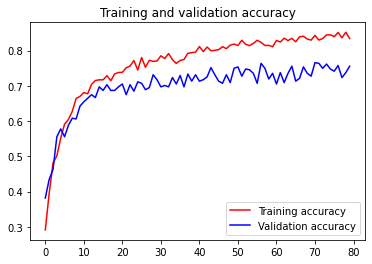

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model = tf.keras.models.load_model('new_transfer_learning.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()#saving converted model in "converted_model.tflite" file
open("new_transfer_learning.tflite", "wb").write(tflite_model)

model1 = tf.keras.models.load_model('new_transfer_learning.h5')
converter1 = tf.lite.TFLiteConverter.from_keras_model(model1)
converter1.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter1.convert()#saving converted model in "converted_quant_model.tflite" file
open("new_transfer_learning_quant.tflite", "wb").write(tflite_quant_model)

21176440

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
!cat labels.txt

cardboard
glass
metal
paper
plastic
trash